<a href="https://colab.research.google.com/github/k3larra/generalisation/blob/pc/shapes_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training model on basic 2D shapes
This code accompanies the paper with the title "Deep Learning, generalisation and concepts".



# Setup

In [1]:
import os
import csv
import sys
import uuid
import shutil
from os import listdir, mkdir
from os.path import isfile, join
import json
import random
random.seed(131254) # Set seed for reproducibility.
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2.0.1+cu118


In [2]:
%%capture
!mkdir '/content/study'
!wget https://raw.githubusercontent.com/k3larra/generalisation/pc/models/models.json -P /content/study

In [3]:
# #Cleaning if needed
# ! rm -r study
# ! rm -r shapes
# ! rm classes.txt

### Training set

In [4]:
#The kaggle token
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"XX","key":"YY"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download smeschke/four-shapes
with ZipFile('/content/four-shapes.zip', 'r') as archive:
  archive.extractall('/content')

mkdir: cannot create directory ‘/root/.kaggle’: File exists
four-shapes.zip: Skipping, found more recently modified local copy (use --force to force download)


## Dataloader


In [5]:
# Create annotation file for training!
shape_path = "/content/shapes"
shapes_to_ignore = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
labels_to_ignore = []
with open('/content/shapes/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("/content/shapes"):
        if dirs in labels_to_ignore: #Ignore label!
          continue
#         print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join("/content/shapes", dirs)):
            if f in shapes_to_ignore: #ignore the images!
              continue
            elif(join("/content/shapes", dirs, f).endswith(".csv")):
                continue
            elif isfile(join("/content/shapes", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [6]:
%%capture
# Create classes
!wget https://raw.githubusercontent.com/k3larra/generalisation/pc/classes.txt -P /content
with open("classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
num_classes = len(categories)

def label_to_idx(label):
  return categories.index(label)

def idx_to_label(idx):
  return categories[idx]

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resizer = transforms.Resize(size=(299, 299))
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image = read_image(img_path,ImageReadMode.RGB)
        image = read_image(img_path,ImageReadMode.UNCHANGED)
        image = image.float()
        image /= 255.
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label_to_idx(label))
        # ADDDITIONS TO TRANSFORM THE INPUT
        r = random.random() # 33% (equal probability) to zoom-in, zoom-out, dont transform
        if r < 0.33: #zoom-in the shape!
          top = random.randrange(0, 40)
          left = top
          dif = 40 - top
          w = 120 + dif
          h = w
          image = transformsF.resized_crop(image, top, left, h, w, size=(200, 200))
        elif r < 0.66: #zoom-out the shape!
          pad = random.randrange(0, 300)
          image = transforms.Pad(padding=pad, fill=1)(image)
        image = self.resizer(image) #Perhaps either native or this? I guess 299,299 is ok since we do 224x 224 later if ResNet but effisientet use [384,384], inception [299,299], but then our shape images are 200,200
        # END OF ADDITIONS!
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.repeat(3, 1, 1)# make RGB
        return image, label

## Create train and validation set

In [8]:
#Models to train
# from torchvision.models import resnet50, ResNet50_Weights
# model_resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# #model_resnet50 = resnet50(weights=None)
# # model_resnet50.weights = "ResNet50_Weights.IMAGENET1K_V2"
# model_resnet50._weights = "Pretrained" ##For the JSON
# model_resnet50._name = "ResNet50" ##For the JSON
# model_resnet50._transforms = "transforms.Resize(size=(299, 299))"
#model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, num_classes)

# from torchvision.models import inception_v3, Inception_V3_Weights
# model_inception_v3 = inception_v3(weights=None)
# model_inception_v3 = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
# model_inception_v3.aux_logits=False #needed for inception
# model_inception_v3._name = "Inception_V3_positive"
# model_inception_v3._weights = "Pretrained" ##For the JSON
# model_inception_v3._transforms = "transforms.Resize(size=(299, 299))"
# model_inception_v3.fc = nn.Linear(model_inception_v3.fc.in_features, num_classes)

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
model_efficientnet_v2_s = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_efficientnet_v2_s._name = "Efficientnet_v2_s"
model_efficientnet_v2_s._weights = "Pretrained" ##For the JSON
model_efficientnet_v2_s._transforms = "transforms.Resize(size=(299, 299))"
model_efficientnet_v2_s.fc = nn.Linear(2048, num_classes)

experiment_models = [model_efficientnet_v2_s]
#experiment_weights= [ResNet50_Weights.IMAGENET1K_V2]

# experiment_models = [model_resnet50,
#                      model_resnet152,
#                      model_googlenet,
#                      model_inception_v3,
#                      model_convnext_tiny]
# experiment_weights= [ResNet50_Weights.IMAGENET1K_V2,
#                      ResNet152_Weights.IMAGENET1K_V2,
#                      GoogLeNet_Weights.IMAGENET1K_V1,
#                      Inception_V3_Weights.IMAGENET1K_V1,
#                      ConvNeXt_Tiny_Weights.IMAGENET1K_V1]

In [9]:
#transform=ResNet50_Weights.IMAGENET1K_V2.transforms()
#shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=transform, target_transform=None)
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=None, target_transform=None)
input, label = shapes_dataset[0]
training_size = int(len(shapes_dataset)*0.9)
validation_size = int(len(shapes_dataset) - training_size)
train_set, val_set = torch.utils.data.random_split(shapes_dataset, [training_size, validation_size], generator=torch.Generator().manual_seed(42)) #Use seed for reproducability
training_loader = DataLoader(train_set, batch_size=16, shuffle=True)  #32,64
validation_loader = DataLoader(val_set, batch_size=16, shuffle=True)  #32,64

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Training set information

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


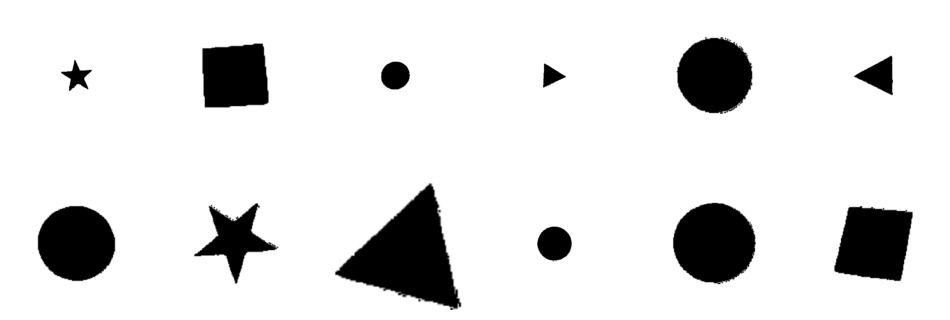

In [10]:
#transform=ResNet50_Weights.IMAGENET1K_V2.transforms()
#shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=transform, target_transform=None)
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=None, target_transform=None)
# I find it strange that using the standard ResNet transform creates images that are not [0..1] or [0..255]
figure = plt.figure(figsize=(12, 4))
cols, rows = 6, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
    sample = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    img, label = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.axis("off")
    plt.imshow(img) # put channel as the last dimension out, vmin=0, vmax=255
plt.show()

In [11]:
for inputs, labels in training_loader:
  print(inputs.shape)
  print('Training set size',int(len(inputs)))
  #print(inputs)
  print(labels.shape)
  break

torch.Size([16, 3, 299, 299])
Training set size 16
torch.Size([16])


# Train and save models

In [12]:
def train_model(model, criterion, optimizer):
    jsonData={}
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / training_size
    epoch_acc = running_corrects.double() / training_size
    jsonData["train_loss"] = round(epoch_loss,3)
    jsonData["epoch_acc"] = round(epoch_acc.item(),3)
    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return jsonData

def test_model(model, criterion):
  jsonData={}
  best_acc = 0.0
  model.eval()   # Set model to evaluate mode
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in validation_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
  epoch_loss = running_loss / validation_size
  epoch_acc = running_corrects.double() / validation_size
  jsonData["test_loss"] = round(epoch_loss,3)
  jsonData["epoch_acc"] = round(epoch_acc.item(),3)
  print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
  return jsonData

In [13]:
#Run training and add information to the JSON file
model_save_path = '/content/study/'
json_filename = 'models.json'
experiment_model=None
num_epochs = 7
if isfile(model_save_path + json_filename) is True:
  with open(model_save_path + json_filename) as outfile:
    experiment_json_data = json.load(outfile)
else:
  experiment_json_data={}
for experiment_model in experiment_models:
  jsonData={}
  id = str(uuid.uuid4())
  complete_model_path = id+'_complete_model.pth'
  jsonData["complete_model_path"] = complete_model_path
  jsonData["model_name"] = experiment_model._name
  jsonData["weights"]= experiment_model._weights
  jsonData["num_epocs"] = num_epochs
  jsonData["transformation"] = experiment_model._transforms
  jsonData["time"] = time.asctime( time.localtime(time.time()))
  print('--')
  #model_ft = experiment_model
  experiment_model.eval()
  experiment_model = experiment_model.to(device)

  print("Training:",experiment_model._name)
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.SGD(experiment_model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  jsonTrain={}
  train=0
  test = 0
  for epoch in range(num_epochs):
      print()
      print('Epoch {}/{}'.format(epoch, num_epochs-1))
      jsonTrain["train_"+str(epoch)] = train_model(experiment_model, criterion, optimizer_ft)
      jsonTrain["test_"+str(epoch)] = test_model(experiment_model, criterion)
      scheduler.step()
  torch.save(experiment_model, model_save_path+complete_model_path)
  jsonData["training"] = jsonTrain
  experiment_json_data[id] = jsonData
with open(model_save_path + json_filename, 'w') as outfile:
  outfile.write(json.dumps(experiment_json_data))

--
Training: Efficientnet_v2_s

Epoch 0/6
train Loss: 0.1999 Acc: 0.9696
test Loss: 0.0003 Acc: 1.0000

Epoch 1/6
train Loss: 0.0048 Acc: 0.9993
test Loss: 0.0001 Acc: 1.0000

Epoch 2/6
train Loss: 0.0023 Acc: 0.9997
test Loss: 0.0001 Acc: 1.0000

Epoch 3/6
train Loss: 0.0018 Acc: 0.9997
test Loss: 0.0001 Acc: 1.0000

Epoch 4/6
train Loss: 0.0012 Acc: 0.9999
test Loss: 0.0001 Acc: 1.0000

Epoch 5/6
train Loss: 0.0013 Acc: 0.9996
test Loss: 0.0000 Acc: 1.0000

Epoch 6/6
train Loss: 0.0010 Acc: 0.9999
test Loss: 0.0001 Acc: 1.0000


In [14]:
zip_name = "trained_models"
shutil.make_archive(zip_name, 'zip', "study")


'/content/trained_models.zip'